# Unsupervised learning Capstone (name TBA)
Author: Matthew Huh
    
## Overview

For the most part, people are free to choose what news outlets they read and follow. In the United States, there is a near-endless list of sites that people can choose from in order to get their daily news and over time, they develop preferences for sites that they are more attached to, and do their best to avoid. Now these affinities are developed through a combination of means ranging from affiliations, vocabulary, prose, and so forth.

What I would like to examine in this project is if it is possible to differentiate from several different publications with their respective perks / quirks. 

## About the Data

This dataset was obtained from Kaggle, and contains a collection of 142,570 articles from 15 different publications.

The publications within this dataset are
1. CNN
2. Breitbart
3. Vox
4. Washington Post
5. New York Post
6. National Review
7. NPR
8. Guardian
9. Talking Points Memo
10. Atlantic
11. Reuters
12. Fox News
13. Business Insider
14. Buzzfeed News
15. New York Times

## Research Question

As this is an unsupervised learning project first and foremost, the project will have 3 goals.

1. The first goal is to prepare the articles in the dataset for modelling using various Natural Language Processing (NLP) methods to re-represent the data in numbers rather than words
2. Cluster the data to determine if we can identify the articles and associate them as different groups.
3. Determine if we can predict the structure of the article based on the publisher.

## Packages

In [49]:
# Basic imports
import os
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning packages
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2
from sklearn.preprocessing import normalize
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Clustering packages
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from scipy.spatial.distance import cdist

# Natural Language processing
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_rcv1

## Data Preview

In [2]:
# Create list of files from directory
filelist = os.listdir('articles')

# Import the files
df_list = [pd.read_csv(file) for file in filelist]

#concatenate them together
articles = pd.concat(df_list)

# Preview the data
articles.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [3]:
# Print the size of the dataset
articles.shape

(142570, 10)

In [4]:
# Sample the dataset for optimal performance
articles = articles.sample(frac=0.1)

In [5]:
# Describe unique occurences for each categorical variable
articles.select_dtypes(include=['object']).nunique()

title          14251
publication       15
author          3936
date            1036
url             8476
content        14248
dtype: int64

In [6]:
# Drop variables that have no impact on the outcome
articles = articles[['title', 'publication', 'author', 'content']]

In [7]:
# View most frequently occurring authors
articles.groupby(['author']).size().sort_values(ascending=False)

author
Breitbart News                                       151
Pam Key                                              146
Associated Press                                     126
Charlie Spiering                                     115
Jerome Hudson                                         94
Joel B. Pollak                                        74
John Hayward                                          74
AWR Hawkins                                           73
Daniel Nussbaum                                       67
Alex Swoyer                                           57
Ian Hanchett                                          56
Warner Todd Huston                                    53
Post Editorial Board                                  49
David A. Graham                                       46
Merrit Kennedy                                        44
Katherine Rodriguez                                   44
Jeff Poor                                             44
NPR Staff               

Well, that partly explains how there are so many authors in this dataset. It seems as though there are over 15,000 authors, and many of them have only published one article, or have co-written multiple articles with other authors. This complicates the problem, so in order to best represent each author's writing style, let's see what happens if we simply remove all authors that only published one article as is.

## Feature Selection

In [8]:
# Drop author from the dataframe if they wrote less than 5 articles
vc = articles['author'].value_counts()
u  = [i not in set(vc[vc<=4].index) for i in articles['author']]
articles = articles[u]

In [9]:
# Reprint how many unique authors there are
articles.select_dtypes(include=['object']).nunique()

title          9354
publication      15
author          605
content        9351
dtype: int64

In [10]:
# View number of articles after feature selection
articles.shape

(9360, 4)

So after removing authors that composed fewer than 5 articles, we are left with 125k articles, or 87.8% of the data, and roughly 3k/15k of the authors. Now, we can create a better representation of each author since each author has at least 5 articles to evaluate from.

In [11]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [12]:
# Remove annoying punctuation from the articles
articles['content'] = articles.content.map(lambda x: text_cleaner(str(x)))
articles.head()

,title,publication,author,content
16755,People Are Laughing/Screaming Over This Sex T...,Buzzfeed News,Julia Reinstein,"’ This is the Sqweel 2, an oral sex simulator ..."
17377,One Child Has Died And Five Others Were Injur...,Buzzfeed News,Salvador Hernandez,Emergency crews on scene at Quality Inn in Nil...
42797,Woman who pushed husband out of high-rise wind...,New York Post,Natalie Musumeci,An Oklahoma woman convicted of murder for shov...
28777,Watch: Trump-Clinton final presidential debate...,Vox,Andrew Prokop,The third and at long last final general elect...
33449,"Please, can someone brief the president on the...",Washington Post,Glenn Kessler,"“When you look for a job, you can’t find it an..."


In [13]:
lemmatizer = WordNetLemmatizer()

# Reduce all text to their lemmas
for article in articles['content']:
    article = lemmatizer.lemmatize(article)

In [14]:
# Identify predictor and target variables
X = articles['content']
y = articles['publication']

# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Tf-idf Vectorization

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=5, # only use words that appear at least twice
                             max_features=150, # limit to 150 best features
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Applying the vectorizer
X_tfidf=vectorizer.fit_transform(X)
print("Number of features: %d" % X_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)

#Removes all zeros from the matrix
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Normalize the dataset    
X_norm = normalize(X_train_tfidf)

# Convert from tf-idf matrix to dataframe
X_normal  = pd.DataFrame(data=X_norm.toarray())

Number of features: 150


### Phrase count with spacy

In [16]:
X_train.shape

(7020,)

In [17]:
# Instantiating spaCy
nlp = spacy.load('en')
X_train_words = []

for row in X_train:
    # Processing each row for tokens
    row_doc = nlp(row)
    # Calculating length of each sentence
    sent_len = len(row_doc) 
    # Initializing counts of different parts of speech
    advs = 0
    verb = 0
    noun = 0
    adj = 0
    for token in row_doc:
        # Identifying each part of speech and adding to counts
        if token.pos_ == 'ADV':
            advs +=1
        elif token.pos_ == 'VERB':
            verb +=1
        elif token.pos_ == 'NOUN':
            noun +=1
        elif token.pos_ == 'ADJ':
            adj +=1
    # Creating a list of all features for each sentence
    X_train_words.append([row_doc, advs, verb, noun, adj, sent_len])

# Create dataframe with count of adverbs, verbs, nouns, and adjectives
X_count = pd.DataFrame(data=X_train_words, columns=['BOW', 'ADV', 'VERB', 'NOUN', 'ADJ', 'sent_length'])

# Change token count to token percentage
for column in X_count.columns[1:5]:
    X_count[column] = X_count[column] / X_count['sent_length']

# Normalize X_count
X_counter = normalize(X_count.drop('BOW',axis=1))
X_counter  = pd.DataFrame(data=X_counter)

In [18]:
# Combine tf-idf matrix and phrase count matrix
features = pd.concat([X_counter,X_normal], ignore_index=False, axis=1)
features.head()

,0,1,2,3,4,0,1,2,3,4,...,140,141,142,143,144,145,146,147,148,149
0,0.000029,0.000172,0.000284,0.000087,1.000000,0.0,0.000000,0.073068,0.0,0.000000,...,0.0,0.233627,0.0,0.000000,0.0,0.0,0.000000,0.141409,0.00000,0.08767
1,0.000093,0.000361,0.000467,0.000220,1.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.172890,0.00000,0.00000
2,0.000103,0.000372,0.000526,0.000263,1.000000,0.0,0.000000,0.517905,0.0,0.215882,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.190630,0.000000,0.15818,0.00000
3,0.000149,0.000810,0.000711,0.000264,0.999999,0.0,0.000000,0.054353,0.0,0.000000,...,0.0,0.000000,0.0,0.147398,0.0,0.0,0.000000,0.000000,0.00000,0.00000
4,0.000082,0.000309,0.000367,0.000192,1.000000,0.0,0.112104,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.105358,0.000000,0.00000,0.00000


In [19]:
# # Instantiating and fitting the 300 best features
# kbest = SelectKBest(f_classif, k=300)
# X2_train = kbest.fit_transform(features, y_train)

# Clustering

### K-means

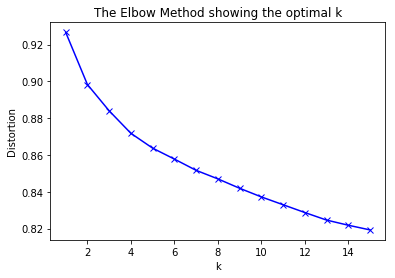

In [40]:
# k means determine k
distortions = []
K = range(1,16)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features)
    kmeanModel.fit(features)
    distortions.append(sum(np.min(cdist(features, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / features.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [29]:
# Calulate predicted values
kmeans = KMeans(n_clusters=15, init='k-means++', random_state=42, n_init=20)
y_pred = kmeans.fit_predict(features)

pd.crosstab(y_train, y_pred)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
publication,,,,,,,,,,,,,,,
Atlantic,27,13,21,22,2,28,117,13,73,24,50,11,17,20,12
Breitbart,343,33,15,109,57,97,129,32,268,90,176,57,37,191,47
Business Insider,85,7,11,18,8,15,61,72,83,15,25,14,0,28,4
Buzzfeed News,42,17,4,22,1,6,22,19,27,2,28,10,0,6,10
CNN,144,21,14,54,3,29,69,12,90,22,81,29,1,34,25
Fox News,49,9,9,24,13,12,11,5,35,6,23,10,6,46,2
Guardian,27,11,5,10,0,7,64,12,54,8,39,18,0,7,10
NPR,39,20,92,25,6,22,85,12,48,13,51,13,11,21,14
National Review,10,10,3,8,13,31,47,1,52,20,26,1,13,23,3


In [30]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_train, y_pred)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(features, y_pred, sample_size=6000, metric='euclidean')))

Adjusted Rand Score: 0.02276652
Silhouette Score: 0.0677047


### Spectral Clustering

In [31]:
sc = SpectralClustering(n_clusters=15)
y_pred3 = sc.fit_predict(features)

pd.crosstab(y_train, y_pred3)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
publication,,,,,,,,,,,,,,,
Atlantic,33,30,38,15,50,14,17,11,13,56,20,26,110,16,1
Breitbart,100,108,83,29,144,30,88,30,47,232,168,399,161,9,53
Business Insider,26,21,29,67,48,6,16,0,4,50,22,71,70,7,9
Buzzfeed News,8,4,12,19,16,18,17,0,10,44,6,37,21,3,1
CNN,39,30,43,8,60,23,41,0,25,142,30,95,78,11,3
Fox News,18,7,8,4,23,8,23,6,1,51,39,44,10,7,11
Guardian,8,9,24,11,39,11,10,0,10,48,6,23,68,5,0
NPR,28,23,25,11,25,21,20,6,13,75,17,28,87,88,5
National Review,35,28,6,1,34,12,6,11,2,30,18,10,54,2,12


In [32]:
print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_train, y_pred3)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(features, y_pred3, metric='euclidean')))

Adjusted Rand Score: 0.02637186
Silhouette Score: 0.05386364


### Affinity Propagation

In [33]:
af = AffinityPropagation()
y_pred4 = af.fit_predict(features)

pd.crosstab(y_train, y_pred4)

col_0,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
publication,,,,,,,,,,,,,,,,,,,,,
Atlantic,4,2,0,9,1,0,3,0,0,1,...,2,1,0,2,1,0,0,1,3,0
Breitbart,0,8,0,18,8,1,3,2,9,7,...,7,1,3,3,8,1,1,4,1,2
Business Insider,0,0,0,4,1,2,0,1,0,0,...,4,0,1,2,2,0,2,0,1,1
Buzzfeed News,0,0,0,5,0,0,0,2,0,3,...,3,1,0,3,0,1,1,2,1,0
CNN,0,2,2,22,1,0,2,2,0,5,...,5,2,0,3,0,0,2,1,0,2
Fox News,0,0,0,4,2,0,2,2,0,2,...,1,0,1,1,0,1,1,0,0,0
Guardian,0,0,5,3,0,0,0,0,0,2,...,3,0,0,0,0,0,1,2,1,0
NPR,0,2,0,6,1,0,0,0,0,2,...,1,4,0,2,1,0,0,0,1,2
National Review,0,0,0,1,0,0,0,0,0,0,...,2,0,0,0,0,0,0,2,1,0


In [34]:
print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_train, y_pred4)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(features, y_pred4, metric='euclidean')))

Adjusted Rand Score: 0.01183964
Silhouette Score: 0.00831869


# Modelling

### Random Forest

In [44]:
rfc = ensemble.RandomForestClassifier()
rfc_train = cross_val_score(rfc, features, y_train, cv=5, n_jobs=-1)

print('Random forest classifier score: {:.5f}(+/- {:.2f})'.format(rfc_train.mean(), rfc_train.std()*2))

Rnadom forest classifier score: 0.40755(+/- 0.01)


### Logistic Regression

In [46]:
lr = LogisticRegression()
lr_train = cross_val_score(lr, features, y_train, cv=5, n_jobs=-1)

print('Logistic regression score: {:.5f}(+/- {:.2f})'.format(lr_train.mean(), lr_train.std()*2))

Logistic regression score: 0.43960(+/- 0.01)


### Gradient Boosting Classifier

In [47]:
gbc = ensemble.GradientBoostingClassifier()
gbc_train = cross_val_score(gbc, features, y_train, cv=5, n_jobs=-1)

print('Gradient boosting classifier score: {:.5f}(+/- {:.2f})'.format(gbc_train.mean(), gbc_train.std()*2))

Gradient boosting classifier score: 0.49074(+/- 0.01)


### Optimized Gradient Boosting Classifier Model 

In [ ]:
# Parameters for gradient boosting classifier
param_grid  = {'loss':['deviance'],
               'max_features': ['sqrt'],
               'n_estimators': [100,200,400],
               'max_depth': [4, 8, 12],
               "min_samples_leaf" : [4, 8, 12]}

# Run grid search to find ideal parameters
gbc_grid = GridSearchCV(gbc, param_grid = param_grid, n_jobs=-1)

# Initialize and fit the model.
gbc_grid.fit(features, y_train)

# Return best parameters and best score
print('Best parameters:')
print(gbc_grid.best_params_)
print('Best Score:')
print(gbc_grid.best_score_)

# Source

https://www.kaggle.com/snapcrack/all-the-news